In [20]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import seaborn as sns
from time import time
from sklearn import manifold, datasets
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding as sp
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import ndimage
from sklearn import manifold, datasets


In [21]:

import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score
ami = adjusted_mutual_info_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(- w)
    acc= sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    
    print('\n')
    print("Accuracy using linear assignment : ",acc)
    print('\n')
    print("Normalized Mutual Info Score : ",nmi(y_true,y_pred))
    print('\n')
    print("Adjusted Mutual Info Score : ",ami(y_true,y_pred))

In [22]:
import matplotlib.pyplot as plt

def graph_plot_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [23]:
#Loading the fashion MNIST dataset

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [24]:
#preprocess the data
max_value = float(X_train.max())
X_train = X_train.astype('float32') / max_value
X_test = X_test.astype('float32') / max_value

In [25]:
X_train.shape

(60000, 28, 28)

In [26]:
#Preprocessing for convolution autoencoder

x_train = X_train.reshape((len(X_train), 28, 28, 1))
x_test = X_test.reshape((len(X_test), 28, 28, 1))


x_train.shape,x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [27]:
#Convolution Autoencoder

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 8)           0         
__________

In [30]:
#The encoder model based on convolution autoencoder

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_2').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
Total para

In [32]:

#Train the convolution autoencoder

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
aehistory=autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 5s 84us/step - loss: 0.2966 - val_loss: 0.2964
Epoch 2/150
60000/60000 [==============================] - 4s 75us/step - loss: 0.2928 - val_loss: 0.2933
Epoch 3/150
60000/60000 [==============================] - 5s 76us/step - loss: 0.2899 - val_loss: 0.2906
Epoch 4/150
52480/60000 [=========================>....] - ETA: 0s - loss: 0.2877

KeyboardInterrupt: 

In [ ]:
graph_plot_loss(aehistory)

In [12]:


autoencoder.save_weights('ae-fmnist-hc.h5')

In [13]:
autoencoder.load_weights('ae-fmnist-hc.h5')

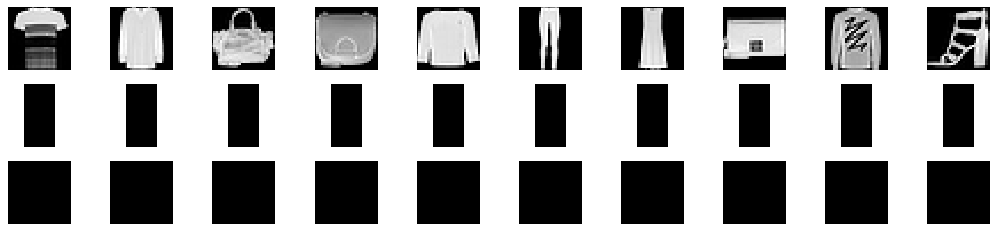

In [15]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
#Now perform dimension reduction

X_train_dr=encoder.predict(x_train)
X_test_dr=encoder.predict(x_test)

print(X_train_dr.shape,X_test_dr.shape)

(60000, 128) (10000, 128)


In [17]:
X1 = X_train_dr
Y= y_train
X1.shape

(60000, 128)

In [18]:
#Kmeans with Convolution Autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)



/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


In [19]:

from sklearn.metrics import confusion_matrix

print ('Results of Kmeans with Convolution Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

acc(y_test,predicted_labels)

Results of Kmeans with Convolution Autoencoder


Confusion Matrix: 

[[1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]


Accuracy using linear assignment :  0.1


Normalized Mutual Info Score :  0.0


Adjusted Mutual Info Score :  0.0


/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in versio

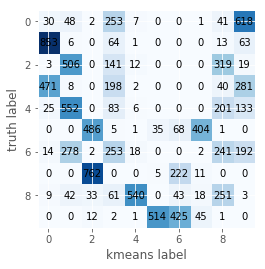

In [33]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

In [34]:
import pandas as pd

In [35]:
datacm=pd.DataFrame(cm)

In [36]:
datacm

,0,1,2,3,4,5,6,7,8,9
0,30,48,2,253,7,0,0,1,41,618
1,853,6,0,64,1,0,0,0,13,63
2,3,506,0,141,12,0,0,0,319,19
3,471,8,0,198,2,0,0,0,40,281
4,25,552,0,83,6,0,0,0,201,133
5,0,0,486,5,1,35,68,404,1,0
6,14,278,2,253,18,0,0,2,241,192
7,0,0,762,0,0,5,222,11,0,0
8,9,42,33,61,540,0,43,18,251,3
9,0,0,12,2,1,514,425,45,1,0


In [34]:
one = [30,48,2,253,7,0,0,1,41,618]
two = [853,6,0,64,1,0,0,0,13,63]
three = [3,506,0,141,12,0,0,0,319,19]
four = [471,8,0,198,2,0,0,0,40,281]
five = [25,552,0,83,6,0,0,0,201,133]
six = [0,0,486,5,1,35,68,404,1,0]
seven = [14,278,2,253,18,0,0,2,241,192]
eight = [0,0,762,0,0,5,222,11,0,0]
nine = [9,42,33,61,540,0,43,18,251,3]
ten = [0,0,12,2,1,514,425,45,1,0]

sim_list = []
sim_list.append(one)
sim_list.append(two)
sim_list.append(three)
sim_list.append(four)
sim_list.append(five)
sim_list.append(six)
sim_list.append(seven)
sim_list.append(eight)
sim_list.append(nine)
sim_list.append(ten)

In [47]:
sm = [[  0,   4, 135,  29,   0, 107,  27, 698,   0,   0],
 [  0,   0,  20, 912,   0,  59,   1,   8,   0,   0],
 [  0, 663, 313,   0,   0,   7,   7,  10,   0,   0],
 [  0,   8,  97, 351,   0, 116,   4, 424,   0,   0],
 [  0, 586, 316,   0,   0,  26,   1,  71,   0,   0],
 [230,   0,  1,  0,387,  3,  8,  0, 25,346],
 [  0,412,272,  5,  0, 60, 28,223,  0,  0],
 [323,  0,  0,  0,653,  0,  3,  0, 14,  7],
 [  2,  0, 28,  0,  3,108,850,  1,  0,  8],
 [278,  0,  1,   0,   4,   2,   1,   0, 677,  37] ]



In [43]:
labels1 = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boat']

[Text(0, 0.5, 'T-shirt'),
 Text(0, 1.5, 'Trouser'),
 Text(0, 2.5, 'Pullover'),
 Text(0, 3.5, 'Dress'),
 Text(0, 4.5, 'Coat'),
 Text(0, 5.5, 'Sandal'),
 Text(0, 6.5, 'Shirt'),
 Text(0, 7.5, 'Sneaker'),
 Text(0, 8.5, 'Bag'),
 Text(0, 9.5, 'Ankle Boat')]

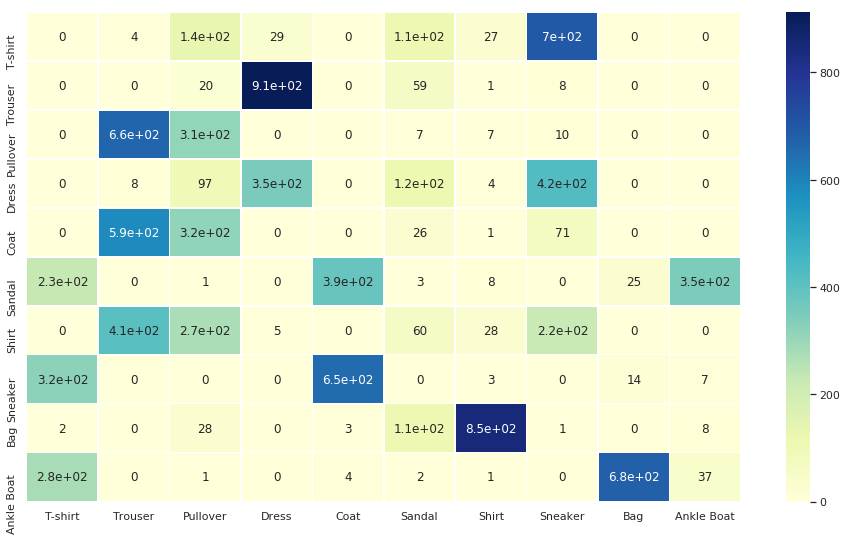

In [48]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
ax = sns.heatmap(sm,annot=True,linewidths=.5,cmap="YlGnBu")
ax.set_xticklabels(labels1)
ax.set_yticklabels(labels1)

In [37]:
#Gaussian Mixture Model for Convolution Autoencoder

from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 


from sklearn.metrics import confusion_matrix

print ('Results of Gaussian Mixture Model with Convolution Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

acc(y_test,plabels)

Results of Gaussian Mixture Model with Convolution Autoencoder


Confusion Matrix: 

[[  0   4 135  29   0 107  27 698   0   0]
 [  0   0  20 912   0  59   1   8   0   0]
 [  0 663 313   0   0   7   7  10   0   0]
 [  0   8  97 351   0 116   4 424   0   0]
 [  0 586 316   0   0  26   1  71   0   0]
 [230   0   1   0 387   3   8   0  25 346]
 [  0 412 272   5   0  60  28 223   0   0]
 [323   0   0   0 653   0   3   0  14   7]
 [  2   0  28   0   3 108 850   1   0   8]
 [278   0   1   0   4   2   1   0 677  37]]


Accuracy using linear assignment :  0.5231


Normalized Mutual Info Score :  0.584094913172731


Adjusted Mutual Info Score :  0.5732644104645698


/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


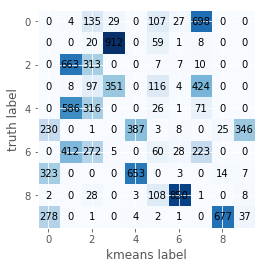

In [38]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, plabels)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

In [39]:
datacm=pd.DataFrame(cm)

In [40]:
datacm

,0,1,2,3,4,5,6,7,8,9
0,0,4,135,29,0,107,27,698,0,0
1,0,0,20,912,0,59,1,8,0,0
2,0,663,313,0,0,7,7,10,0,0
3,0,8,97,351,0,116,4,424,0,0
4,0,586,316,0,0,26,1,71,0,0
5,230,0,1,0,387,3,8,0,25,346
6,0,412,272,5,0,60,28,223,0,0
7,323,0,0,0,653,0,3,0,14,7
8,2,0,28,0,3,108,850,1,0,8
9,278,0,1,0,4,2,1,0,677,37


/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


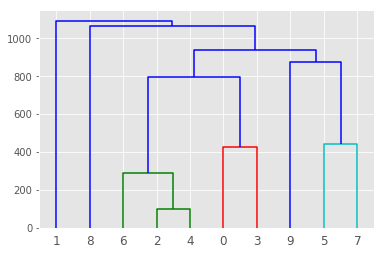

In [41]:
from scipy.cluster import hierarchy
Y = hierarchy.distance.pdist(datacm.as_matrix(), metric='euclidean')
Z = hierarchy.linkage(Y, method='average')
ax = hierarchy.dendrogram(Z, show_contracted=True, labels=datacm.index.tolist())

In [18]:
np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((16, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X1, Y)

In [19]:
y.shape

(10000,)

In [20]:
# Visualize the clustering
def plot_clustering(X_red,X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

In [21]:
# 2D embedding of the dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X1)
print("Done.")

Computing embedding
Done.


In [22]:
X_red.shape

(5000, 2)

ward : 0.54s
average : 0.55s
complete : 0.49s


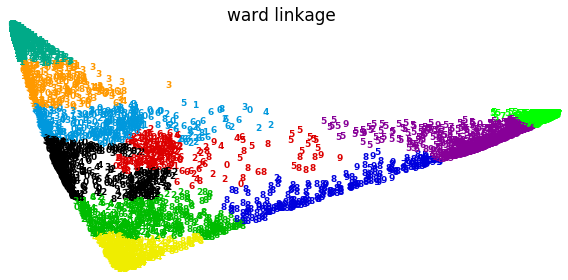

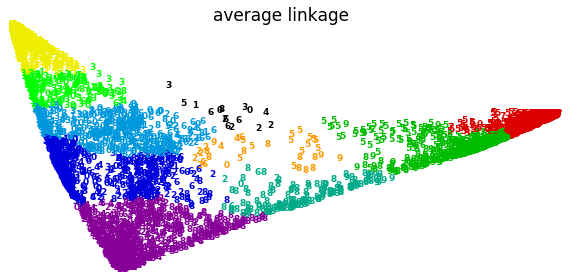

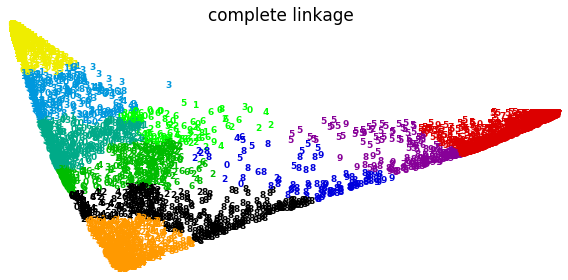

<Figure size 432x288 with 0 Axes>

In [23]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red,X, clustering.labels_, "%s linkage" % linkage)
plt.show()
plt.savefig('fmnist_cae_linkage.pdf')

In [30]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=10)
clustering.fit(X_red)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=10,
                        pooling_func='deprecated')

In [33]:
clustering.linkage

'average'

In [24]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

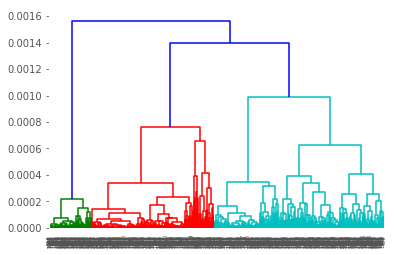

In [28]:

Z = hierarchy.linkage(X_red[:1500,:], 'average')
plt.figure()
plt.savefig('fmnist_cae_dg.png')
dn = hierarchy.dendrogram(Z)